In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import sys
sys.path.append('../')

In [3]:
from utils import get_checkpoint_config

checkpoint_dir = '../../../../../ray_results/PPO_Detrended/PPO_buy_sell_hold_pct_ewma_13_clip_param=0.3,alpha=0.25,gamma=0.99,lr=5e-05,fcnet_hiddens=[64, 64],train_batch_size=4000_2020-05-11_18-55-34lyuztn5w/'
config, checkpoint_path = get_checkpoint_config(checkpoint_dir, 136)

In [4]:
from utils import RestoredAgent
from ray.rllib.agents.ppo import ppo
from train_env import env_name
import quandl


agent = RestoredAgent(
    config=config, env=env_name, trainer=ppo.PPOTrainer,
    checkpoint=checkpoint_path
)

2020-05-11 21:20:35,068	INFO resource_spec.py:212 -- Starting Ray with 8.06 GiB memory available for workers and up to 4.05 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-05-11 21:20:35,402	INFO services.py:1170 -- View the Ray dashboard at localhost:8267
2020-05-11 21:20:36,038	INFO trainer.py:421 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution
2020-05-11 21:20:36,093	INFO trainer.py:580 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2020-05-11 21:20:38,270	INFO trainable.py:217 -- Getting current IP.
2020-05-11 21:20:38,271	WARNING util.py:37 -- Install gputil for GPU system monitoring.
2020-05-11 21:20:38,313	INFO trainable.py:217 -- Getting current IP.
2020-05-11 21:20:38,314	INFO trainable.py:423 -- Restored on 192.168.1.107 from checkpoint: ../../../../../ray_results/PPO_Detrended/PPO_buy_sell_hold_pct_ewma_13_clip

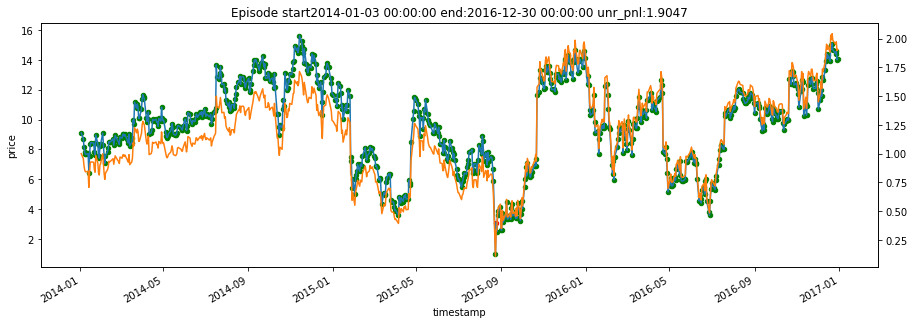

In [5]:
from train_env import buy_sell_hold_pct_ewma
from buy_sell_hold import episode_df
from plotting import plot_episode
from utils import run_agent


train_config = config['env_config'].copy()
train_config.pop('episode_length')
env = buy_sell_hold_pct_ewma(train_config)
observations, rewards, actions, infos = run_agent(agent, env)
ep_df = episode_df(observations, rewards, actions, infos)
plot_episode(ep_df)

In [12]:
ep_df.action.value_counts(normalize=True)

0    1.0
Name: action, dtype: float64

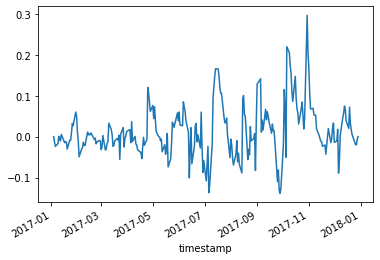

In [14]:
ep_df['observation'].plot();

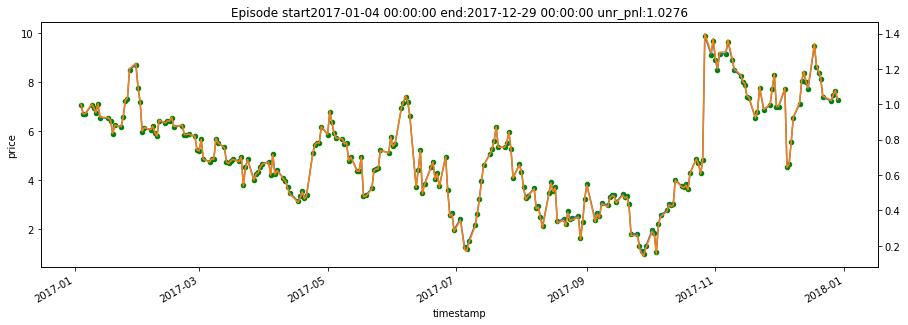

2020-05-11 21:20:43,871	ERROR worker.py:1030 -- Possible unhandled error from worker: ray::RolloutWorker.__init__() (pid=287392, ip=192.168.1.107)
  File "python/ray/_raylet.pyx", line 427, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 444, in ray._raylet.execute_task
  File "/home/olledahlen/.pyenv/versions/rl_trading/lib/python3.6/site-packages/ray/serialization.py", line 317, in deserialize_objects
    self._deserialize_object(data, metadata, object_id))
  File "/home/olledahlen/.pyenv/versions/rl_trading/lib/python3.6/site-packages/ray/serialization.py", line 257, in _deserialize_object
    return self._deserialize_msgpack_data(data, metadata)
  File "/home/olledahlen/.pyenv/versions/rl_trading/lib/python3.6/site-packages/ray/serialization.py", line 238, in _deserialize_msgpack_data
    python_objects = self._deserialize_pickle5_data(pickle5_data)
  File "/home/olledahlen/.pyenv/versions/rl_trading/lib/python3.6/site-packages/ray/serialization.py", line 226, in 

In [6]:
import my_secrets
from utils import detrend

test_config = config['env_config'].copy()
test_config.pop('episode_length')

open_prices = (
    quandl.get('WIKI/MSFT',
               start_date="2017-01-01",
               end_date="2018-01-01",
               api_key=my_secrets.quandl_api_key)
    .assign(Open=lambda df: detrend(df['Open']))
    .assign(Open=lambda df: df['Open'] - df['Open'].min() + 1)
    ['Open']
)

test_config['price_series'] = open_prices

env = buy_sell_hold_pct_ewma(test_config)
observations, rewards, actions, infos = run_agent(agent, env)
ep_df = episode_df(observations, rewards, actions, infos)
plot_episode(ep_df)